# Machine Translation

Небольшой проект по переводу текста с русского языка на английский

## 1. Данные

Я выбрал корпус текстов OpenSubtitle (http://www.opensubtitles.org/) с ресурса OPUS (https://opus.nlpl.eu/OpenSubtitles/ru&en/v2018/OpenSubtitles)

Раскомментируйте ячейку снизу и запустите ее для скачивания данных или сделайте это вручную

In [1]:
# !wget -q -O data/en-ru.txt.zip https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-ru.txt.zip
# !unzip data/en-ru.txt.zip -d data
# !mv data/OpenSubtitles.en-ru.en data/en.txt
# !mv data/OpenSubtitles.en-ru.ru data/ru.txt
# !rm data/en-ru.txt.zip
# !rm data/OpenSubtitles.en-ru.ids

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, concatenate_datasets, load_from_disk, Dataset, DatasetDict
import random
import os

%matplotlib inline

sns.set_style("darkgrid")
sns.set_context("notebook")

Зафиксируем random seed для детерминированности всех процессов

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Прочитаем данные с помощью библиотеки HuggingFace Datasets, разделим данные на тренировочную (80%), валидационную (10%) и тестовую (10%) выборки, а также закэшируем получившийся датасет, чтобы не выполнять этих действий в дальнейшем

In [4]:
def split_dataset(
    dataset: Dataset, valid_size: float, test_size: float, seed: int | None = None
) -> DatasetDict:
    testvalid_size = valid_size + test_size

    train_testvalid = dataset.train_test_split(test_size=testvalid_size, seed=seed)

    test_valid = train_testvalid["test"].train_test_split(
        test_size=(test_size / testvalid_size), seed=seed
    )

    return DatasetDict(
        {
            "train": train_testvalid["train"],
            "valid": test_valid["train"],
            "test": test_valid["test"],
        }
    )

In [5]:
if not os.path.exists("data/machine-translation"):
    dataset = load_dataset(
        "text",
        data_files={"ru": "data/ru.txt", "en": "data/en.txt"},
        cache_dir="data",
    )

    dataset["ru"] = dataset["ru"].rename_column("text", "ru")
    dataset["en"] = dataset["en"].rename_column("text", "en")
    dataset.cleanup_cache_files()
    dataset = concatenate_datasets(list(dataset.values()), axis=1)
    
    dataset = split_dataset(dataset, valid_size=0.1, test_size=0.1, seed=seed)

    dataset.save_to_disk("data/machine-translation")
else:
    dataset = load_from_disk("data/machine-translation")
dataset

DatasetDict({
    train: Dataset({
        features: ['ru', 'en'],
        num_rows: 20728084
    })
    valid: Dataset({
        features: ['ru', 'en'],
        num_rows: 2591010
    })
    test: Dataset({
        features: ['ru', 'en'],
        num_rows: 2591011
    })
})

Просмотрим некоторые примеры из корпуса

In [6]:
example_fragment = dataset["train"][:5]

for i, (ru, en) in enumerate(zip(example_fragment["ru"], example_fragment["en"])):
    print(f"{i + 1}. {ru} --- {en}")

1. Я не могу поверить в это. --- I don't believe it.
2. Хочешь поуправлять мной? --- Want to boss me around?
3. Но никогда, никогда не покажет своих настоящих намерений. --- But never, never will it reveal its real intent.
4. Возможно, ты их убил, Митч. --- You may have killed them, Mitch.
5. Он похож на вас, в каком-то смысле. --- He's like you in a way.


Посмотрим, как выглядит распределение длин текстов на русском и английском языках. Для этого вначале замапим значения длин в датасет

In [7]:
dataset = dataset.map(
    lambda example: {"ru_len": len(example["ru"]), "en_len": len(example["en"])}
)
dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/machine-translation/train/cache-b814b059418ba24a.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/machine-translation/valid/cache-19a07dad14e7df57.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/machine-translation/test/cache-58513d459626f9de.arrow


DatasetDict({
    train: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 20728084
    })
    valid: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 2591010
    })
    test: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 2591011
    })
})

Хочется визуализировать данные, но сделать это со всем датасетом кажется не лучшим решением ввиду его размеров. Попробуем визуализировать длины текстов на обоих языках для какой-то части данных. Будем держать в голове, что возможны некоторые выбросы, о которых мы позаботимся дальше

In [8]:
def plot_lengths(dataset: Dataset, n_to_show: int, bins: int = 20, log_scale: bool = False):
    _, ax = plt.subplots(1, 2, figsize=(10, 5))

    fragment = dataset[:n_to_show]

    sns.histplot(x=fragment["ru_len"], ax=ax[0], log_scale=log_scale, bins=bins)
    sns.histplot(x=fragment["en_len"], ax=ax[1], log_scale=log_scale, bins=bins)

    ax[0].set_title(f"Russian lengths ({n_to_show} examples)")
    ax[1].set_title(f"English lengths ({n_to_show} examples)")

    ax[0].set_xlabel("Length")
    ax[1].set_xlabel("Length")

    plt.show()

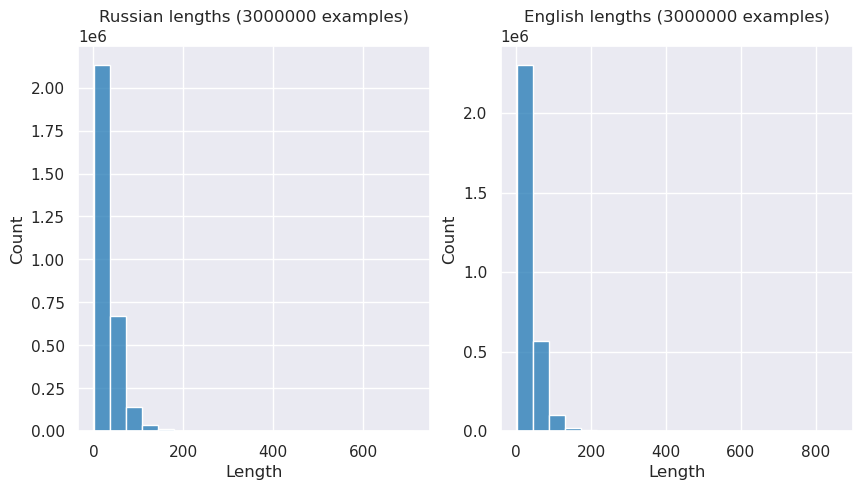

In [9]:
plot_lengths(dataset["train"], n_to_show=3_000_000)

Как видим, большая часть текстов имеет небольшую длину. Посмотрим на некоторые статистики этих распределений: среднее, разброс и 99% перцентиль

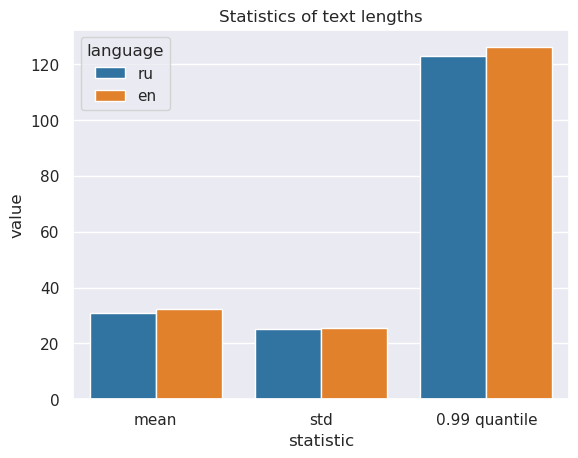

In [10]:
def plot_length_statistics(dataset: Dataset, quantile: float):
    ru_len_array = np.array(dataset["ru_len"])
    en_len_array = np.array(dataset["en_len"])

    len_stats = {"statistic": [], "value": [], "language": []}

    for statistic, name in zip(
        [np.mean, np.std, lambda a: np.quantile(a, quantile)], ["mean", "std", f"{quantile} quantile"]
    ):
        for arr, lang in zip([ru_len_array, en_len_array], ["ru", "en"]):
            len_stats["value"].append(statistic(arr))
            len_stats["statistic"].append(name)
            len_stats["language"].append(lang)

    len_stats = pd.DataFrame(len_stats)

    sns.barplot(len_stats, x="statistic", y="value", hue="language")
    plt.title("Statistics of text lengths")
    plt.show()

plot_length_statistics(dataset["train"], quantile=0.99)

Как видим, распределения довольно похожи. Более того, 99% всех текстов имеют длину менее 125 символов. Оставим только эти короткие тексты, поскольку перед нами не стоит задача создать Google Translator. Мы сконцентрируемся на переводах небольших текстов, состоящих из одного-двух предложений

Отфильтруем также и отложенные выборки (валидационную и тестовую), поскольку мы хотим получить адекватные метрики

In [11]:
len_threshold = 125

print("Before filtration")
print(f'Train size: {dataset["train"].num_rows}')
print(f'Valid size: {dataset["valid"].num_rows}')
print(f'Test size: {dataset["test"].num_rows}')

def filter_by_length(example):
    return example["ru_len"] < len_threshold and example["en_len"] < len_threshold

dataset["train"] = dataset["train"].filter(filter_by_length)
dataset["valid"] = dataset["valid"].filter(filter_by_length)
dataset["test"] = dataset["test"].filter(filter_by_length)

print('After filtration')
print(f'Train size: {dataset["train"].num_rows}')
print(f'Valid size: {dataset["valid"].num_rows}')
print(f'Test size: {dataset["test"].num_rows}')

Before filtration
Train size: 20728084
Valid size: 2591010
Test size: 2591011


Filter:   0%|          | 0/20728084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2591010 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2591011 [00:00<?, ? examples/s]

After filtration
Train size: 20449395
Valid size: 2556298
Test size: 2555812


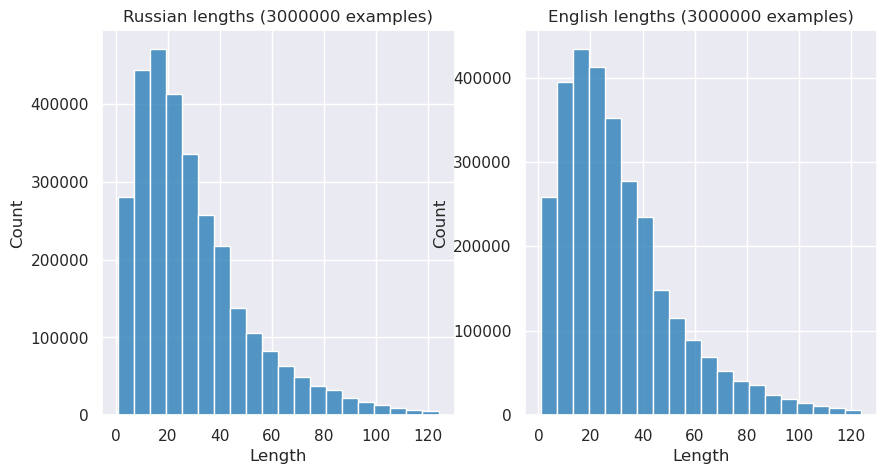

In [12]:
plot_lengths(dataset["train"], n_to_show=3_000_000)